In [ ]:
import pdb
import os
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import numpy as np
from PIL import Image

In [ ]:
base_path = "/content/drive/MyDrive/DL/final_project/pix2code"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
batch_size = 4
embed_size = 512
attention_dim = 512
decoder_dim = 512
hidden_size = 512
num_layers = 1
alpha_c = 1.
grad_clip = 5.
encoder_lr = 1e-4
decoder_lr = 4e-4

shuffle = True
num_workers = 2

save_after_x_epochs = 2
log_step = 1

data_dir = base_path+'/datasets/web/processed_data/data_train/' 
model_path = base_path+'/model/'
vocab_path = base_path+'/bootstrap.vocab'

crop_size = 224 # Required by resnet152

In [ ]:
base_path

'/content/drive/MyDrive/DL/final_project/pix2code'

Load Data

In [ ]:
import os
import random
from tqdm import tqdm
from shutil import copyfile

raw_data_dir = data_dir
assert os.path.isdir(data_dir)

output_dir = base_path+'/datasets/web/processed_data/'
filenames = os.listdir(raw_data_dir)

filenames = [(f[:-3] + 'gui', f[:-3] + 'png') for f in filenames if f.endswith('.gui')]

random.seed(12345)
filenames.sort()
random.shuffle(filenames)

split_1 = int(0.8 * len(filenames))
split_2 = int(0.9 * len(filenames))

filenames = {
    'train': filenames[:split_1],
    'dev': filenames[split_1:split_2],
    'test': filenames[split_2:]
}

if not os.path.exists(output_dir):
    os.mkdir(output_dir)
else:
    print('Warning: output dir {} already exists.'.format(output_dir))

for split in ['train', 'dev', 'test']:
    output_dir_split = os.path.join(output_dir, 'data_{}'.format(split))
    
    if not os.path.exists(output_dir_split):
        os.mkdir(output_dir_split)
    else:
        print('Warning: output dir {} already exists.'.format(output_dir_split))
        
    print('Processing {} data, saving to {}.'.format(split, output_dir_split))
    
    for (gui, png) in tqdm(filenames[split]):
        src_path_gui = os.path.join(raw_data_dir, gui)
        output_path_gui = os.path.join(output_dir_split, gui)
        src_path_png = os.path.join(raw_data_dir, png)
        output_path_png = os.path.join(output_dir_split, png)
        
        copyfile(src_path_gui, output_path_gui)
        copyfile(src_path_png, output_path_png)

Build Vocab

In [ ]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [ ]:
class Vocabulary (object):
    def __init__ (self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        
    def add_word (self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
    
    def __call__ (self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]
    
    def __len__ (self):
        return len(self.word2idx)

In [ ]:
def build_vocab (vocab_file_path):
    vocab = Vocabulary()

    words_raw = load_doc(vocab_file_path)
    words = set(words_raw.split(' '))
    
    for i, word in enumerate(words):
        vocab.add_word(word)

    vocab.add_word(' ')
    vocab.add_word('<unk>')
    
    print('Created vocabulary of ' + str(len(vocab)) + ' items from ' + vocab_file_path)
    
    return vocab


In [ ]:
vocab = build_vocab(vocab_path)

vocab_size = len(vocab)

Created vocabulary of 19 items from /content/drive/MyDrive/DL/final_project/pix2code/bootstrap.vocab


Build Images and Captions

In [ ]:
class ImageHTMLDataSet (Dataset):
    def __init__ (self, data_dir, vocab, transform):
        self.data_dir = data_dir
        self.vocab = vocab
        self.transform = transform
        
        self.raw_image_names = []
        self.raw_captions = []
        
        self.filenames = os.listdir(data_dir)
        self.filenames.sort()
  
        for filename in self.filenames:
            if filename[-3:] == 'png':

                self.raw_image_names.append(filename)
            elif filename[-3:] == 'gui':
                data = load_doc(data_dir + filename)
                self.raw_captions.append(data)
                
        print('Created dataset of ' + str(len(self)) + ' items from ' + data_dir)

    def __len__ (self):
        return len(self.raw_image_names)
    
    def __getitem__ (self, idx):
        img_path, raw_caption = self.raw_image_names[idx], self.raw_captions[idx]
        

        image = Image.open(os.path.join(self.data_dir, img_path)).convert('RGB')
        image = self.transform(image)

        caption = []
        caption.append(self.vocab('<START>'))

        tokens = ' '.join(raw_caption.split())
        tokens = tokens.replace(',', ' ,')
        tokens = tokens.split(' ')
        
        caption.extend([self.vocab(token) for token in tokens])
        caption.append(self.vocab('<END>'))
        
        target = torch.Tensor(caption)
        
        return image, target

def collate_fn (data):
    data.sort(key = lambda data_pair: len(data_pair[1]), reverse=True)
    images, captions = zip(*data)
    
    images = torch.stack(images, 0)
    
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    
    for i, caption in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = caption[:end]
        
    return images, targets, lengths

In [ ]:

transform = transforms.Compose([
    transforms.Resize((crop_size, crop_size)), #resnet size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_html_dataset = ImageHTMLDataSet(data_dir=data_dir, vocab=vocab, transform=transform)
data_loader = DataLoader(dataset=img_html_dataset,
                         batch_size=batch_size,
                         shuffle=shuffle,
                         num_workers=num_workers,
                         collate_fn=collate_fn, drop_last=True)

Created dataset of 1393 items from /content/drive/MyDrive/DL/final_project/pix2code/datasets/web/processed_data/data_train/


Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, encoded_image_size=2048):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101(pretrained=True) 
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        self.linear = nn.Linear(in_features = resnet.fc.in_features, out_features = encoded_image_size)
        self.bn = nn.BatchNorm1d(num_features = encoded_image_size, momentum = 0.01)
      
        self.fine_tune()

    def forward(self, images):

        out = self.resnet(images)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.bn(out)
        return out

    def fine_tune(self, fine_tune=True):
        for p in self.resnet.parameters():
            p.requires_grad = False
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune


In [ ]:
MAX_LENGTH = 5

In [ ]:
embed_size

512

In [ ]:
import torch
from torch import nn
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Attention(nn.Module):

    def __init__(self, encoder_dim, decoder_dim, attention_dim):

        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):

        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha


class DecoderWithAttention(nn.Module):

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  
        self.init_weights()  
        
    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out) 
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  
        num_pixels = encoder_out.size(1)
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        embeddings = self.embedding(encoded_captions) 

        h, c = self.init_hidden_state(encoder_out) 

        decode_lengths = (caption_lengths - 1).tolist()


        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  
            preds = self.fc(self.dropout(h))  
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [ ]:
encoder = Encoder()
decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=embed_size,
                                       decoder_dim=decoder_dim,
                                       vocab_size=len(vocab),
                                       dropout=0.2)

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()
    print('CUDA activated.')

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

CUDA activated.


In [ ]:
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr)
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)

In [ ]:
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)



In [ ]:
from collections import defaultdict
history = defaultdict()
history['loss'], history['perp'],history['time'] = [],[],[]

In [ ]:
import time

In [ ]:
encoder.train()
decoder.train()

batch_count = len(data_loader)
t0=time.time()
# history['time'].append(t0)
for epoch in range(10):
    for i, (images, captions, lengths) in enumerate(data_loader):

        images = Variable(images.cuda())
        captions = Variable(captions.cuda())

        lengths = torch.tensor(lengths)

        encoder.zero_grad()
        decoder.zero_grad()

        features = encoder(images) 
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, captions, lengths.unsqueeze(1))

        targets = captions[:,1:]
        scores = nn.utils.rnn.pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets = nn.utils.rnn.pack_padded_sequence(targets, decode_lengths, batch_first=True)

        loss = criterion(scores.data.double(), targets.data)
        loss.backward()

        clip_gradient(encoder_optimizer, grad_clip)
        clip_gradient(decoder_optimizer, grad_clip)

        encoder_optimizer.step()
        decoder_optimizer.step()

        
        if epoch % log_step == 0 and i == 0:
            history['loss'].append(loss.item())
            history['perp'].append(np.exp(loss.item()))
            history['time'].append(time.time()-t0)
            print('Epoch: #%d, Loss: %.4f, Perplexity: %5.4f'
                  % (epoch, loss.item(), np.exp(loss.item())))
            
        if (epoch + 1) % save_after_x_epochs == 0 and i == 0:
            # Save our models
            print('Saving model ' + str(epoch))
            torch.save(decoder.state_dict(),os.path.join(model_path, 'decoder-hp2-%d-%d.pkl' %(epoch+1, i+1)))
            torch.save(encoder.state_dict(), os.path.join(model_path, 'encoder-hp2-%d-%d.pkl' %(epoch+1, i+1)))

timeTaken = time.time()-t0
print('done!')

Epoch: #0, Loss: 3.0073, Perplexity: 20.2317
Epoch: #1, Loss: 0.2453, Perplexity: 1.2781
Saving model 1
Epoch: #2, Loss: 0.1927, Perplexity: 1.2126
Epoch: #3, Loss: 0.1852, Perplexity: 1.2035
Saving model 3
Epoch: #4, Loss: 0.2012, Perplexity: 1.2229
Epoch: #5, Loss: 0.1237, Perplexity: 1.1317
Saving model 5
Epoch: #6, Loss: 0.1192, Perplexity: 1.1266
Epoch: #7, Loss: 0.0958, Perplexity: 1.1005
Saving model 7
Epoch: #8, Loss: 0.1101, Perplexity: 1.1164
Epoch: #9, Loss: 0.0751, Perplexity: 1.0780
Saving model 9
done!


In [ ]:
import os

In [ ]:
torch.save(decoder.state_dict(),'/content/drive/MyDrive/DL/decoder-hp2-%d-%d.pkl' %(epoch+1, i+1))
torch.save(encoder.state_dict(), '/content/drive/MyDrive/DL/encoder-hp2-%d-%d.pkl' %(epoch+1, i+1))

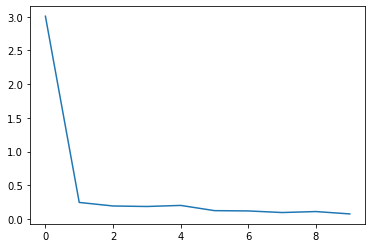

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history['loss'])

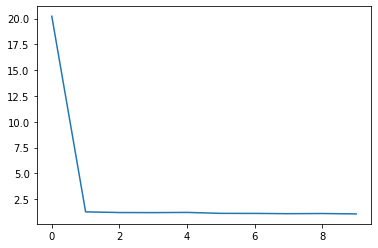

In [ ]:
plt.plot(history['perp'])

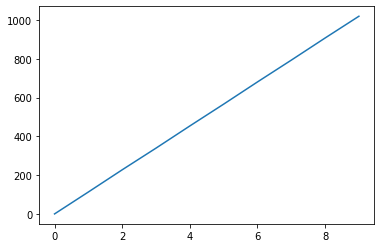

In [ ]:
plt.plot(history['time'])

In [ ]:
import json 
with open(base_path+'/history_hp2.json','w') as f:
  json.dump(history,f)

Eval

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
def transform_idx_to_words (input):
    sampled_caption = []
    
    for idx in input:
        word = vocab.idx2word[idx]
        sampled_caption.append(word)

        if word == '<END>':
            break

    output = ' '.join(sampled_caption[1:-1])

    output = output.replace(' ,', ',')

    return output.split(' ')

In [ ]:
dev_data_dir = base_path+'/datasets/web/processed_data/data_dev/'

models_to_test = ['2-1','4-1','6-1','8-1','10-1']

Greedy Search

In [ ]:
bleu_scores = []

for model_idx, model_name in enumerate(models_to_test):
    encoder_model_path = os.path.join(model_path, 'encoder-hp2-{}.pkl'.format(model_name))
    decoder_model_path = os.path.join(model_path, 'decoder-hp2-{}.pkl'.format(model_name))
    
    dev_img_html_dataset = ImageHTMLDataSet(data_dir=dev_data_dir, vocab=vocab, transform=transform)
    
    dev_data_loader = DataLoader(dataset=dev_img_html_dataset,
                             batch_size=1,
                             shuffle=shuffle,
                             num_workers=num_workers,
                             collate_fn=collate_fn)
    
    dev_encoder = Encoder()
    dev_decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=embed_size,
                                       decoder_dim=decoder_dim,
                                       vocab_size=len(vocab),
                                       dropout=0.2)

    dev_encoder.load_state_dict(torch.load(encoder_model_path))
    dev_decoder.load_state_dict(torch.load(decoder_model_path))

    if torch.cuda.is_available():
        dev_encoder.cuda()
        dev_decoder.cuda()

    dev_encoder.eval()
    dev_decoder.eval()
    
    dev_data_count = len(dev_data_loader.dataset)

    predicted, actual = list(), list()
    bleu=0.
    for i, (images, captions, lengths) in enumerate(dev_data_loader):
        images = Variable(images.cuda())

        captions = Variable(captions.cuda())

        lengths = torch.tensor(lengths)

        dev_encoder.zero_grad()
        dev_decoder.zero_grad()
        
        features = dev_encoder(images) 
        scores, caps_sorted, decode_lengths, alphas, sort_ind = dev_decoder(features, captions, lengths.unsqueeze(1))

        targets = captions[:,1:]

        scores = nn.utils.rnn.pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets = nn.utils.rnn.pack_padded_sequence(targets, decode_lengths, batch_first=True)

        predicted = list(np.argmax(scores.data.detach().cpu().numpy(),axis=1))
        actual = list(targets.data.detach().cpu().numpy())


        predicted = [vocab.idx2word[item] for item in predicted]
        actual = [vocab.idx2word[item] for item in actual]

    
        bleu+=corpus_bleu(actual, predicted)
    
    bleu_scores.append((model_name, bleu/len(dev_data_loader.dataset)))
                    
    print('done with {} items for model: {}'.format(str(len(predicted)), model_name))

Created dataset of 174 items from /content/drive/MyDrive/DL/final_project/pix2code/datasets/web/processed_data/data_dev/


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


done with 76 items for model: 2-1
Created dataset of 174 items from /content/drive/MyDrive/DL/final_project/pix2code/datasets/web/processed_data/data_dev/
done with 72 items for model: 4-1
Created dataset of 174 items from /content/drive/MyDrive/DL/final_project/pix2code/datasets/web/processed_data/data_dev/
done with 48 items for model: 6-1
Created dataset of 174 items from /content/drive/MyDrive/DL/final_project/pix2code/datasets/web/processed_data/data_dev/
done with 78 items for model: 8-1
Created dataset of 174 items from /content/drive/MyDrive/DL/final_project/pix2code/datasets/web/processed_data/data_dev/
done with 74 items for model: 10-1


In [ ]:
bleu_scores

[('2-1', 0.6821744511881205),
 ('4-1', 0.6830318112673441),
 ('6-1', 0.675798928641526),
 ('8-1', 0.6765190789158899),
 ('10-1', 0.6771639003037694)]

# **Test**

In [ ]:
test_data_dir = base_path+'/datasets/web/processed_data/data_test/'

chosen_model = ['4-1']

In [ ]:
bleu_scores = []

for model_idx, model_name in enumerate(chosen_model):
    encoder_model_path = os.path.join(model_path, 'encoder-hp2-{}.pkl'.format(model_name))
    decoder_model_path = os.path.join(model_path, 'decoder-hp2-{}.pkl'.format(model_name))
    
    dev_img_html_dataset = ImageHTMLDataSet(data_dir=test_data_dir, vocab=vocab, transform=transform)
    
    dev_data_loader = DataLoader(dataset=dev_img_html_dataset,
                             batch_size=1,
                             shuffle=shuffle,
                             num_workers=num_workers,
                             collate_fn=collate_fn)
    
    dev_encoder = Encoder()
    dev_decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=embed_size,
                                       decoder_dim=decoder_dim,
                                       vocab_size=len(vocab),
                                       dropout=0.2)

    dev_encoder.load_state_dict(torch.load(encoder_model_path))
    dev_decoder.load_state_dict(torch.load(decoder_model_path))

    if torch.cuda.is_available():
        dev_encoder.cuda()
        dev_decoder.cuda()

    dev_encoder.eval()
    dev_decoder.eval()
    
    dev_data_count = len(dev_data_loader.dataset)

    predicted, actual = list(), list()
    bleu=0.
    for i, (images, captions, lengths) in enumerate(dev_data_loader):
        images = Variable(images.cuda())

        captions = Variable(captions.cuda())

        lengths = torch.tensor(lengths)

        dev_encoder.zero_grad()
        dev_decoder.zero_grad()
        
        features = dev_encoder(images) 
        scores, caps_sorted, decode_lengths, alphas, sort_ind = dev_decoder(features, captions, lengths.unsqueeze(1))

        targets = captions[:,1:]

        scores = nn.utils.rnn.pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets = nn.utils.rnn.pack_padded_sequence(targets, decode_lengths, batch_first=True)

        predicted = list(np.argmax(scores.data.detach().cpu().numpy(),axis=1))
        actual = list(targets.data.detach().cpu().numpy())


        predicted = [vocab.idx2word[item] for item in predicted]
        actual = [vocab.idx2word[item] for item in actual]

    
        bleu+=corpus_bleu(actual, predicted)
    
    bleu_scores.append((model_name, bleu/len(dev_data_loader.dataset)))
                    
    print('done with {} items for model: {}'.format(str(len(predicted)), model_name))

Created dataset of 175 items from /content/drive/MyDrive/DL/final_project/pix2code/datasets/web/processed_data/data_test/


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


done with 78 items for model: 4-1


In [ ]:
bleu_scores

[('4-1', 0.5088399072211138)]